# 机器学习与深度学习 第二次作业
**常响 3022210027**
本项目地址：
## 任务概要
### 环境
- Ubuntu LTS 24.04
- GPU/Driver：4090/560.35.03
- Cuda: 12.6
- Pytorch: 2.5.1

### 任务概要
1. 在两个建议的数据集上微调模型（LeNet-5）的架构，并观察模型结果
2. 在两个建议的数据集上微调模型（LeNet-5）的归一化方法与Batch-size，并观察模型结果
3. 分析不同优化方法下的模型训练结果
4. 尝试两种视觉注意力机制，并比较不同注意力机制的识别精度

## 一些参数

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
H, W = 64, 64
batch_size = 64
cifar_train_dataset_path = './data'

## 数据下载与预处理

In [2]:
%%bash
mkdir -p ./data
if [ ! -d ./data/cifar-10-batches-py ]; then
    curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -o ./data/cifar-10-python.tar.gz > /dev/null
    tar -xvzf ./data/cifar-10-python.tar.gz -C ./data > /dev/null
    rm ./data/cifar-10-python.tar.gz > /dev/null
fi

In [3]:
%%bash
mkdir -p ./data
if [ ! -d ./data/tiny-imagenet-200 ]; then
    curl https://cs231n.stanford.edu/tiny-imagenet-200.zip -o ./data/tiny-imagenet-200.zip > /dev/null
    unzip ./data/tiny-imagenet-200.zip -d ./data > /dev/null
    rm ./data/tiny-imagenet-200.zip > /dev/null
fi

In [4]:
# import libs
%matplotlib inline
%load_ext autoreload
%autoreload 2
import math
import time
import numpy as np
import os 
from os.path import join
import torch
import torch.utils.data as data
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt


In [5]:
# 定义一个计时器，方便后面的使用（这里参考了李沐老师的 D2L 课程）
from timer import Timer

# Test
n = 10000
a = np.ones([n])
b = np.ones([n])
c = np.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.00372 sec'

接下来我们定义数据集增强的两个方法

In [6]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2023, 0.1994, 0.2010) # 或者 (0.247, 0.243, 0.261) 也很常见

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # CIFAR-10 图像是 32x32
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
])

我们实现了一个类，用来读取部分的子数据集（原始数据集太大啦，训练压力太大）

In [7]:
trainset = torchvision.datasets.CIFAR10(
    root=cifar_train_dataset_path,
    train=True,
    download=True, # 如果本地没有，会自动下载到 cifar_train_dataset_path/cifar-10-batches-py
    transform=transform_train
)
print(f"CIFAR-10 训练集加载成功，样本数: {len(trainset)}")
print(f"CIFAR-10 类别: {trainset.classes}")


testset = torchvision.datasets.CIFAR10(
    root=cifar_train_dataset_path,
    train=False,
    download=True,
    transform=transform_test
)
print(f"CIFAR-10 测试集加载成功，样本数: {len(testset)}")

Files already downloaded and verified
CIFAR-10 训练集加载成功，样本数: 50000
CIFAR-10 类别: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Files already downloaded and verified
CIFAR-10 测试集加载成功，样本数: 10000


In [9]:
train_loader = DataLoader(
    trainset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=16
)

test_loader = DataLoader(
    testset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=16
)

print(f"\nCIFAR-10 DataLoader 创建成功。")
print(f"训练 DataLoader 每个批次:")
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(f"  图像形状: {images.shape}")
print(f"  标签形状: {labels.shape}")
print(f"  一个标签示例: {labels[0].item()} (类别索引)")
print(f"  对应类别名: {trainset.classes[labels[0].item()]}")


CIFAR-10 DataLoader 创建成功。
训练 DataLoader 每个批次:
  图像形状: torch.Size([64, 3, 32, 32])
  标签形状: torch.Size([64])
  一个标签示例: 7 (类别索引)
  对应类别名: horse


## 基础模型：LeNet-5
### 正向传播
LeNet-5的基本架构如下图所示

![image.png](./LeNet-5-Structure.png)

`basic_lenet.py`中对其进行了实现，接下来我们测试一下前向传播（为了适配数据集中的10分类，每个卷积层的设计和LeNet5不完全相同，但大体结构是相似的）

In [10]:
from basic_lenet import BasicLeNet

for batch_idx, (data, target) in enumerate(train_loader):
    net = BasicLeNet()
    net.to(device)
    input_tensor=data.to(device)
    print(input_tensor.shape)
    timer = Timer()
    output = net.forward(input_tensor)
    print(f'{timer.stop():.5f} sec')
    print(output.shape)
    break

torch.Size([64, 3, 32, 32])
0.23572 sec
torch.Size([64, 10])


### 反向传播与预测实现
接下来，我们来实现反向传播与预测（实现同样请见`basic_lenet.py`）

--- Epoch 1/50 ---


Train Epoch: 1 [1856/50000 (4%)]	loss: 2.300917
Train Epoch: 1 [3776/50000 (8%)]	loss: 2.299797
Train Epoch: 1 [5696/50000 (11%)]	loss: 2.295256
Train Epoch: 1 [7616/50000 (15%)]	loss: 2.293822
Train Epoch: 1 [9536/50000 (19%)]	loss: 2.283941
Train Epoch: 1 [11456/50000 (23%)]	loss: 2.281088
Train Epoch: 1 [13376/50000 (27%)]	loss: 2.286322
Train Epoch: 1 [15296/50000 (31%)]	loss: 2.272749
Train Epoch: 1 [17216/50000 (34%)]	loss: 2.269211
Train Epoch: 1 [19136/50000 (38%)]	loss: 2.292125
Train Epoch: 1 [21056/50000 (42%)]	loss: 2.269154
Train Epoch: 1 [22976/50000 (46%)]	loss: 2.200096
Train Epoch: 1 [24896/50000 (50%)]	loss: 2.185243
Train Epoch: 1 [26816/50000 (54%)]	loss: 2.143987
Train Epoch: 1 [28736/50000 (57%)]	loss: 2.255059
Train Epoch: 1 [30656/50000 (61%)]	loss: 2.135582
Train Epoch: 1 [32576/50000 (65%)]	loss: 2.108394
Train Epoch: 1 [34496/50000 (69%)]	loss: 2.152728
Train Epoch: 1 [36416/50000 (73%)]	loss: 2.199280
Train Epoch: 1 [38336/50000 (77%)]	loss: 2.185850
Train E

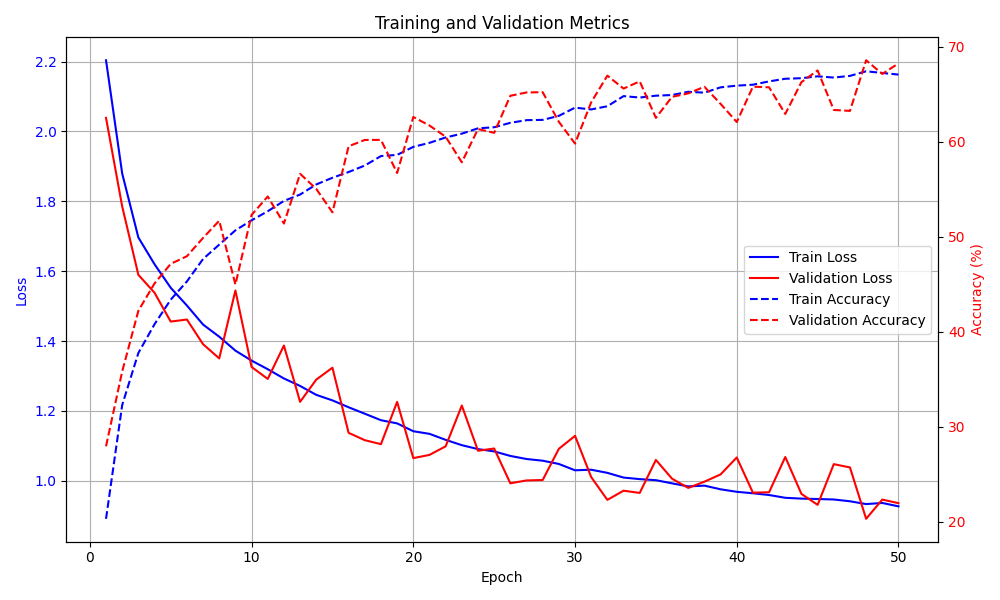

In [56]:
from basic_lenet import BasicLeNet, train, test 
import torch.optim as optim
from plot import plot_training_metrics
from IPython.display import Image as IPImage

model = BasicLeNet()
model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.0)
EPOCHS = 50

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, EPOCHS + 1):
    print(f"--- Epoch {epoch}/{EPOCHS} ---")
    epoch_train_loss, epoch_train_acc = train(model, device, train_loader, optimizer, epoch)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(epoch_train_acc)
    print(f"Epoch {epoch} - Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.2f}%")
    epoch_val_loss, epoch_val_acc = test(model, device, test_loader)
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    print(f"Epoch {epoch} - Validation Loss: {epoch_val_loss:.4f}, Validation Accuracy: {epoch_val_acc:.2f}%")

print("\n--- 训练完成 ---")

plot_save_path = 'cifar10_training_metrics.png' 
plot_training_metrics(train_losses, train_accuracies, val_losses, val_accuracies, EPOCHS, save_path=plot_save_path)
print(f"训练指标图已保存到: {plot_save_path}")

display(IPImage(filename=plot_save_path))

## 对LeNet的微调
### 对层架构和层激活函数进行微调
我们使用SDG优化器以保证相同的优化器条件下验证不同架构下的训练效果

首先，我们来分析不同滤波器大小对模型训练效果造成对影响
### Conv Kernel_size 5 Vs kernel_size 7


开始训练模型 1...
--- 模型 1: Epoch 1/50 ---


Train Epoch: 1 [1856/50000 (4%)]	loss: 2.298109
Train Epoch: 1 [3776/50000 (8%)]	loss: 2.306190
Train Epoch: 1 [5696/50000 (11%)]	loss: 2.303900
Train Epoch: 1 [7616/50000 (15%)]	loss: 2.303694
Train Epoch: 1 [9536/50000 (19%)]	loss: 2.294529
Train Epoch: 1 [11456/50000 (23%)]	loss: 2.302213
Train Epoch: 1 [13376/50000 (27%)]	loss: 2.301318
Train Epoch: 1 [15296/50000 (31%)]	loss: 2.289082
Train Epoch: 1 [17216/50000 (34%)]	loss: 2.303812
Train Epoch: 1 [19136/50000 (38%)]	loss: 2.295090
Train Epoch: 1 [21056/50000 (42%)]	loss: 2.269984
Train Epoch: 1 [22976/50000 (46%)]	loss: 2.316451
Train Epoch: 1 [24896/50000 (50%)]	loss: 2.277486
Train Epoch: 1 [26816/50000 (54%)]	loss: 2.246945
Train Epoch: 1 [28736/50000 (57%)]	loss: 2.291780
Train Epoch: 1 [30656/50000 (61%)]	loss: 2.245037
Train Epoch: 1 [32576/50000 (65%)]	loss: 2.189546
Train Epoch: 1 [34496/50000 (69%)]	loss: 2.249797
Train Epoch: 1 [36416/50000 (73%)]	loss: 2.301596
Train Epoch: 1 [38336/50000 (77%)]	loss: 2.171911
Train E

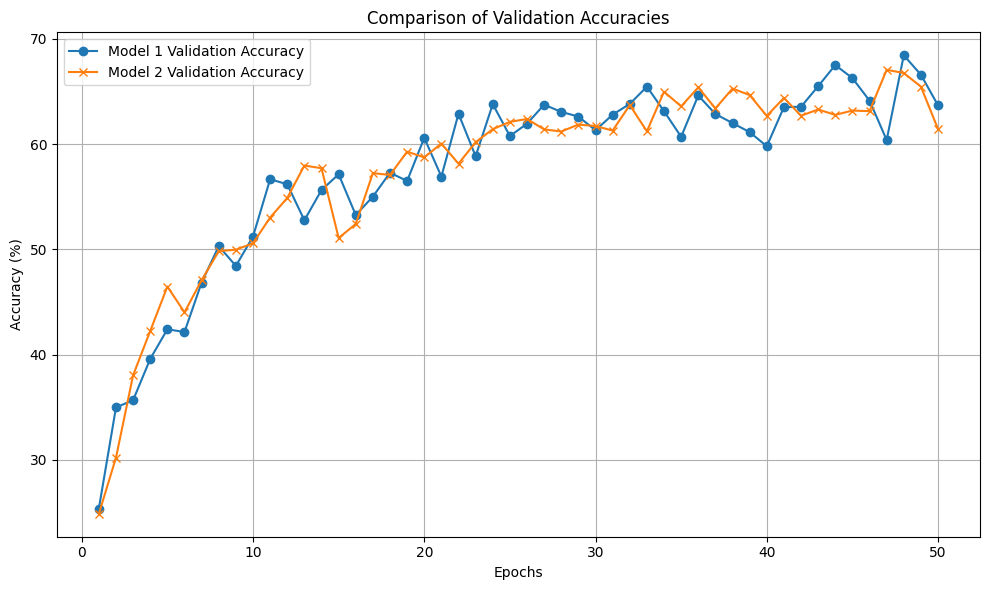

In [ ]:
from basic_lenet import BasicLeNet, train, test 
from lenet_k6 import LenetK6, train, test 
import torch.optim as optim
import matplotlib.pyplot as plt

EPOCHS = 50
LEARNING_RATE_MODEL1 = 0.01
LEARNING_RATE_MODEL2 = 0.01

model1 = BasicLeNet()
model1.to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=LEARNING_RATE_MODEL1, momentum=0.0)

model2 = LenetK6()
model2.to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=LEARNING_RATE_MODEL2, momentum=0.0)

val_accuracies_model1 = []
val_accuracies_model2 = []

print("\n开始训练模型 1...")
for epoch in range(1, EPOCHS + 1):
    print(f"--- 模型 1: Epoch {epoch}/{EPOCHS} ---")
    train_loss1, train_acc1 = train(model1, device, train_loader, optimizer1, epoch)
    print(f"模型 1 Epoch {epoch} - Training Loss: {train_loss1:.4f}, Training Accuracy: {train_acc1:.2f}%")
    val_loss1, val_acc1 = test(model1, device, test_loader)
    val_accuracies_model1.append(val_acc1)
    print(f"模型 1 Epoch {epoch} - Validation Loss: {val_loss1:.4f}, Validation Accuracy: {val_acc1:.2f}%")

print("\n开始训练模型 2...")
for epoch in range(1, EPOCHS + 1):
    print(f"--- 模型 2: Epoch {epoch}/{EPOCHS} ---")
    train_loss2, train_acc2 = train(model2, device, train_loader, optimizer2, epoch)
    print(f"模型 2 Epoch {epoch} - Training Loss: {train_loss2:.4f}, Training Accuracy: {train_acc2:.2f}%")
    val_loss2, val_acc2 = test(model2, device, test_loader)
    val_accuracies_model2.append(val_acc2)
    print(f"模型 2 Epoch {epoch} - Validation Loss: {val_loss2:.4f}, Validation Accuracy: {val_acc2:.2f}%")

print("\n--- 所有模型训练完成 ---")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, val_accuracies_model1, label='Model 1 Validation Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies_model2, label='Model 2 Validation Accuracy', marker='x')
plt.title('Comparison of Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('comparison_validation_accuracies.png') 
plt.show()

接下来我们比较两种不同激活函数的训练效果 ReLU和Tanh
### ReLU VS Tanh


开始训练模型 1...
--- 模型 1: Epoch 1/50 ---
Train Epoch: 1 [1856/50000 (4%)]	loss: 2.303239
Train Epoch: 1 [3776/50000 (8%)]	loss: 2.294207
Train Epoch: 1 [5696/50000 (11%)]	loss: 2.291981
Train Epoch: 1 [7616/50000 (15%)]	loss: 2.289006
Train Epoch: 1 [9536/50000 (19%)]	loss: 2.303657
Train Epoch: 1 [11456/50000 (23%)]	loss: 2.277125
Train Epoch: 1 [13376/50000 (27%)]	loss: 2.268050
Train Epoch: 1 [15296/50000 (31%)]	loss: 2.286240
Train Epoch: 1 [17216/50000 (34%)]	loss: 2.264531
Train Epoch: 1 [19136/50000 (38%)]	loss: 2.271336
Train Epoch: 1 [21056/50000 (42%)]	loss: 2.232359
Train Epoch: 1 [22976/50000 (46%)]	loss: 2.230035
Train Epoch: 1 [24896/50000 (50%)]	loss: 2.216094
Train Epoch: 1 [26816/50000 (54%)]	loss: 2.244571
Train Epoch: 1 [28736/50000 (57%)]	loss: 2.247063
Train Epoch: 1 [30656/50000 (61%)]	loss: 2.194483
Train Epoch: 1 [32576/50000 (65%)]	loss: 2.300061
Train Epoch: 1 [34496/50000 (69%)]	loss: 2.145611
Train Epoch: 1 [36416/50000 (73%)]	loss: 2.292495
Train Epoch: 1 [383

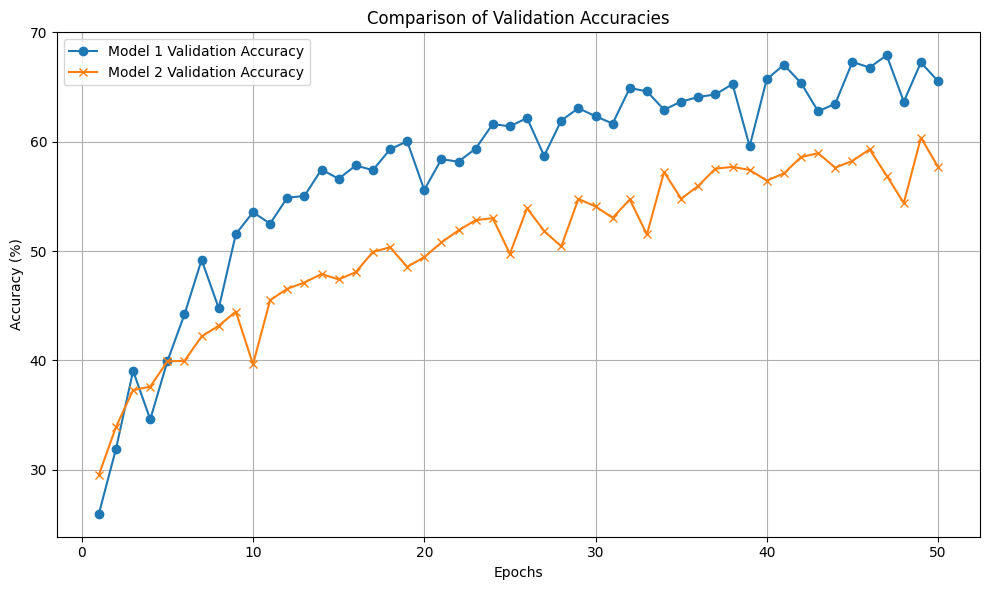

In [14]:
from basic_lenet import BasicLeNet, train, test 
from lenet_tanh import LenetTanh
import torch.optim as optim
import matplotlib.pyplot as plt

EPOCHS = 50
LEARNING_RATE_MODEL1 = 0.01
LEARNING_RATE_MODEL2 = 0.01

model1 = BasicLeNet()
model1.to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=LEARNING_RATE_MODEL1, momentum=0.0)

model2 = LenetTanh()
model2.to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=LEARNING_RATE_MODEL2, momentum=0.0)

val_accuracies_model1 = []
val_accuracies_model2 = []

print("\n开始训练模型 1...")
for epoch in range(1, EPOCHS + 1):
    print(f"--- 模型 1: Epoch {epoch}/{EPOCHS} ---")
    train_loss1, train_acc1 = train(model1, device, train_loader, optimizer1, epoch)
    print(f"模型 1 Epoch {epoch} - Training Loss: {train_loss1:.4f}, Training Accuracy: {train_acc1:.2f}%")
    val_loss1, val_acc1 = test(model1, device, test_loader)
    val_accuracies_model1.append(val_acc1)
    print(f"模型 1 Epoch {epoch} - Validation Loss: {val_loss1:.4f}, Validation Accuracy: {val_acc1:.2f}%")

print("\n开始训练模型 2...")
for epoch in range(1, EPOCHS + 1):
    print(f"--- 模型 2: Epoch {epoch}/{EPOCHS} ---")
    train_loss2, train_acc2 = train(model2, device, train_loader, optimizer2, epoch)
    print(f"模型 2 Epoch {epoch} - Training Loss: {train_loss2:.4f}, Training Accuracy: {train_acc2:.2f}%")
    val_loss2, val_acc2 = test(model2, device, test_loader)
    val_accuracies_model2.append(val_acc2)
    print(f"模型 2 Epoch {epoch} - Validation Loss: {val_loss2:.4f}, Validation Accuracy: {val_acc2:.2f}%")

print("\n--- 所有模型训练完成 ---")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, val_accuracies_model1, label='Model 1 Validation Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies_model2, label='Model 2 Validation Accuracy', marker='x')
plt.title('Comparison of Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('comparison_validation_accuracies.png') 
plt.show()

通过训练曲线，我们可以看出，Tanh的训练效果不如ReLU，接下来，我们来比较两种不同的归一化方法：BN和无归一化
### BN VS None Nomalization


开始训练模型 1...
--- 模型 1: Epoch 1/50 ---
Train Epoch: 1 [1856/50000 (4%)]	loss: 2.306710
Train Epoch: 1 [3776/50000 (8%)]	loss: 2.299799
Train Epoch: 1 [5696/50000 (11%)]	loss: 2.306803
Train Epoch: 1 [7616/50000 (15%)]	loss: 2.296217
Train Epoch: 1 [9536/50000 (19%)]	loss: 2.294934
Train Epoch: 1 [11456/50000 (23%)]	loss: 2.295550
Train Epoch: 1 [13376/50000 (27%)]	loss: 2.306117
Train Epoch: 1 [15296/50000 (31%)]	loss: 2.288743
Train Epoch: 1 [17216/50000 (34%)]	loss: 2.284709
Train Epoch: 1 [19136/50000 (38%)]	loss: 2.305030
Train Epoch: 1 [21056/50000 (42%)]	loss: 2.296369
Train Epoch: 1 [22976/50000 (46%)]	loss: 2.242147
Train Epoch: 1 [24896/50000 (50%)]	loss: 2.262346
Train Epoch: 1 [26816/50000 (54%)]	loss: 2.279652
Train Epoch: 1 [28736/50000 (57%)]	loss: 2.275799
Train Epoch: 1 [30656/50000 (61%)]	loss: 2.258791
Train Epoch: 1 [32576/50000 (65%)]	loss: 2.273107
Train Epoch: 1 [34496/50000 (69%)]	loss: 2.178285
Train Epoch: 1 [36416/50000 (73%)]	loss: 2.244672
Train Epoch: 1 [383

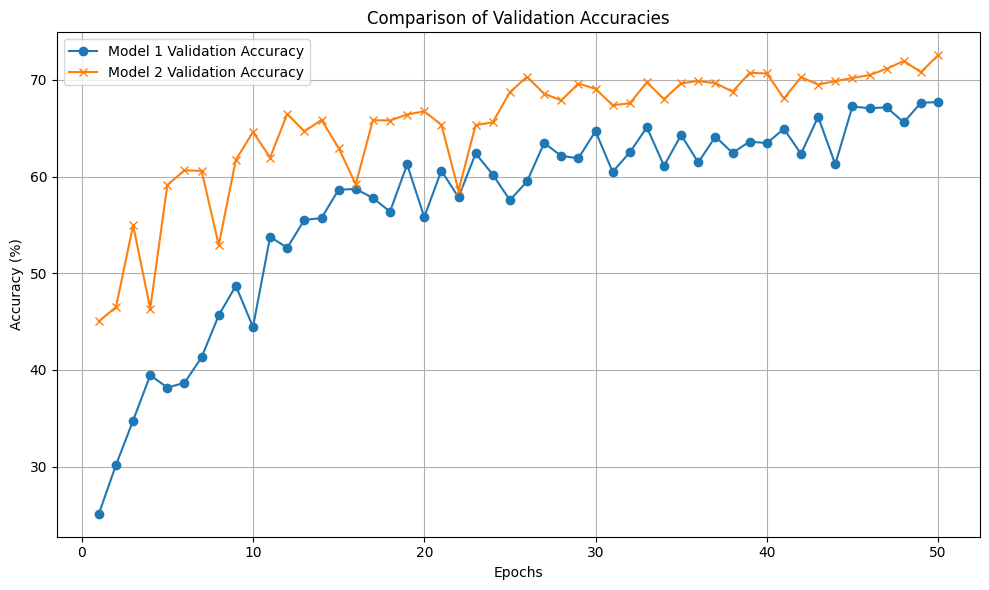

In [15]:
from basic_lenet import BasicLeNet, train, test 
from lenet_with_bn import LenetWithBN
import torch.optim as optim
import matplotlib.pyplot as plt

EPOCHS = 50
LEARNING_RATE_MODEL1 = 0.01
LEARNING_RATE_MODEL2 = 0.01

model1 = BasicLeNet()
model1.to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=LEARNING_RATE_MODEL1, momentum=0.0)

model2 = LenetWithBN()
model2.to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=LEARNING_RATE_MODEL2, momentum=0.0)

val_accuracies_model1 = []
val_accuracies_model2 = []

print("\n开始训练模型 1...")
for epoch in range(1, EPOCHS + 1):
    print(f"--- 模型 1: Epoch {epoch}/{EPOCHS} ---")
    train_loss1, train_acc1 = train(model1, device, train_loader, optimizer1, epoch)
    print(f"模型 1 Epoch {epoch} - Training Loss: {train_loss1:.4f}, Training Accuracy: {train_acc1:.2f}%")
    val_loss1, val_acc1 = test(model1, device, test_loader)
    val_accuracies_model1.append(val_acc1)
    print(f"模型 1 Epoch {epoch} - Validation Loss: {val_loss1:.4f}, Validation Accuracy: {val_acc1:.2f}%")

print("\n开始训练模型 2...")
for epoch in range(1, EPOCHS + 1):
    print(f"--- 模型 2: Epoch {epoch}/{EPOCHS} ---")
    train_loss2, train_acc2 = train(model2, device, train_loader, optimizer2, epoch)
    print(f"模型 2 Epoch {epoch} - Training Loss: {train_loss2:.4f}, Training Accuracy: {train_acc2:.2f}%")
    val_loss2, val_acc2 = test(model2, device, test_loader)
    val_accuracies_model2.append(val_acc2)
    print(f"模型 2 Epoch {epoch} - Validation Loss: {val_loss2:.4f}, Validation Accuracy: {val_acc2:.2f}%")

print("\n--- 所有模型训练完成 ---")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, val_accuracies_model1, label='Model 1 Validation Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies_model2, label='Model 2 Validation Accuracy', marker='x')
plt.title('Comparison of Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('comparison_validation_accuracies.png') 
plt.show()

可以看到，在批归一化的加持下，收敛速度和训练效果均有了很大提升！
接下来，我们来分析不同优化器的优化效果
### Opitimiser: SGD VS AdaDelta


开始训练模型 1...
--- 模型 1: Epoch 1/50 ---
Train Epoch: 1 [1856/50000 (4%)]	loss: 2.287115
Train Epoch: 1 [3776/50000 (8%)]	loss: 2.284893
Train Epoch: 1 [5696/50000 (11%)]	loss: 2.144487
Train Epoch: 1 [7616/50000 (15%)]	loss: 2.043368
Train Epoch: 1 [9536/50000 (19%)]	loss: 2.063019
Train Epoch: 1 [11456/50000 (23%)]	loss: 1.940007
Train Epoch: 1 [13376/50000 (27%)]	loss: 1.862128
Train Epoch: 1 [15296/50000 (31%)]	loss: 1.835393
Train Epoch: 1 [17216/50000 (34%)]	loss: 1.867267
Train Epoch: 1 [19136/50000 (38%)]	loss: 1.709735
Train Epoch: 1 [21056/50000 (42%)]	loss: 1.844858
Train Epoch: 1 [22976/50000 (46%)]	loss: 1.806135
Train Epoch: 1 [24896/50000 (50%)]	loss: 1.541033
Train Epoch: 1 [26816/50000 (54%)]	loss: 1.784421
Train Epoch: 1 [28736/50000 (57%)]	loss: 1.653156
Train Epoch: 1 [30656/50000 (61%)]	loss: 1.627182
Train Epoch: 1 [32576/50000 (65%)]	loss: 1.725992
Train Epoch: 1 [34496/50000 (69%)]	loss: 1.663778
Train Epoch: 1 [36416/50000 (73%)]	loss: 1.848998
Train Epoch: 1 [383

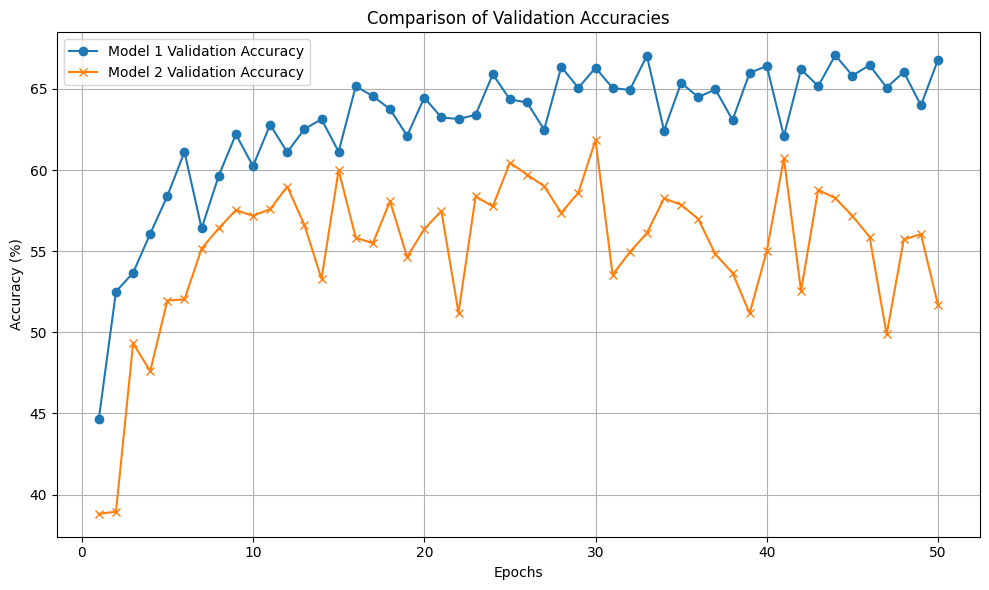

In [16]:
from basic_lenet import BasicLeNet, train, test 
import torch.optim as optim
import matplotlib.pyplot as plt

EPOCHS = 50
LEARNING_RATE_MODEL1 = 0.01
LEARNING_RATE_MODEL2 = 0.01

model1 = BasicLeNet()
model1.to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=LEARNING_RATE_MODEL1, momentum=0.9)

model2 = BasicLeNet()
model2.to(device)
optimizer2 = optim.Adadelta(model2.parameters())

val_accuracies_model1 = []
val_accuracies_model2 = []

print("\n开始训练模型 1...")
for epoch in range(1, EPOCHS + 1):
    print(f"--- 模型 1: Epoch {epoch}/{EPOCHS} ---")
    train_loss1, train_acc1 = train(model1, device, train_loader, optimizer1, epoch)
    print(f"模型 1 Epoch {epoch} - Training Loss: {train_loss1:.4f}, Training Accuracy: {train_acc1:.2f}%")
    val_loss1, val_acc1 = test(model1, device, test_loader)
    val_accuracies_model1.append(val_acc1)
    print(f"模型 1 Epoch {epoch} - Validation Loss: {val_loss1:.4f}, Validation Accuracy: {val_acc1:.2f}%")

print("\n开始训练模型 2...")
for epoch in range(1, EPOCHS + 1):
    print(f"--- 模型 2: Epoch {epoch}/{EPOCHS} ---")
    train_loss2, train_acc2 = train(model2, device, train_loader, optimizer2, epoch)
    print(f"模型 2 Epoch {epoch} - Training Loss: {train_loss2:.4f}, Training Accuracy: {train_acc2:.2f}%")
    val_loss2, val_acc2 = test(model2, device, test_loader)
    val_accuracies_model2.append(val_acc2)
    print(f"模型 2 Epoch {epoch} - Validation Loss: {val_loss2:.4f}, Validation Accuracy: {val_acc2:.2f}%")

print("\n--- 所有模型训练完成 ---")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, val_accuracies_model1, label='Model 1 Validation Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies_model2, label='Model 2 Validation Accuracy', marker='x')
plt.title('Comparison of Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('comparison_validation_accuracies.png') 
plt.show()

AdaDelta的训练效果不如带动量的SGD，可能和AdaDelta的初始超参数设置不当有关
### 注意力机制
我们在批归一化的基础上分别实现了SE、ECA的注意力机制


开始训练模型 1...
--- 模型 1: Epoch 1/50 ---


/root/miniconda3/lib/python3.12/site-packages/torch/nn/init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Train Epoch: 1 [1856/50000 (4%)]	loss: 2.048628
Train Epoch: 1 [3776/50000 (8%)]	loss: 2.065797
Train Epoch: 1 [5696/50000 (11%)]	loss: 1.607695
Train Epoch: 1 [7616/50000 (15%)]	loss: 1.712681
Train Epoch: 1 [9536/50000 (19%)]	loss: 1.824287
Train Epoch: 1 [11456/50000 (23%)]	loss: 1.629654
Train Epoch: 1 [13376/50000 (27%)]	loss: 1.820940
Train Epoch: 1 [15296/50000 (31%)]	loss: 1.588697
Train Epoch: 1 [17216/50000 (34%)]	loss: 1.848036
Train Epoch: 1 [19136/50000 (38%)]	loss: 1.778872
Train Epoch: 1 [21056/50000 (42%)]	loss: 1.679999
Train Epoch: 1 [22976/50000 (46%)]	loss: 1.664363
Train Epoch: 1 [24896/50000 (50%)]	loss: 1.462989
Train Epoch: 1 [26816/50000 (54%)]	loss: 1.687489
Train Epoch: 1 [28736/50000 (57%)]	loss: 1.418991
Train Epoch: 1 [30656/50000 (61%)]	loss: 1.695431
Train Epoch: 1 [32576/50000 (65%)]	loss: 1.546860
Train Epoch: 1 [34496/50000 (69%)]	loss: 1.644472
Train Epoch: 1 [36416/50000 (73%)]	loss: 1.496574
Train Epoch: 1 [38336/50000 (77%)]	loss: 1.330027
Train E

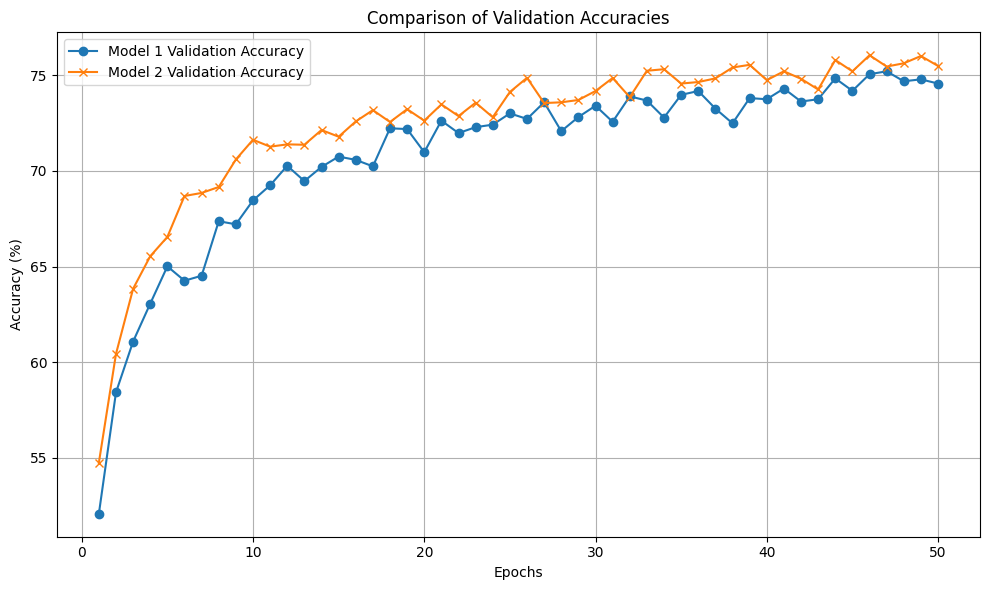

In [17]:
from lenet_with_se import LenetWithSE, train, test 
from lenet_with_eca import LenetWithECA
import torch.optim as optim
import matplotlib.pyplot as plt

EPOCHS = 50
LEARNING_RATE_MODEL1 = 0.01
LEARNING_RATE_MODEL2 = 0.01

model1 = LenetWithSE()
model1.to(device)
optimizer1 = optim.SGD(model1.parameters(), lr=LEARNING_RATE_MODEL1, momentum=0.9)

model2 = LenetWithECA()
model2.to(device)
optimizer2 = optim.SGD(model2.parameters(), lr=LEARNING_RATE_MODEL2, momentum=0.9)

val_accuracies_model1 = []
val_accuracies_model2 = []

print("\n开始训练模型 1...")
for epoch in range(1, EPOCHS + 1):
    print(f"--- 模型 1: Epoch {epoch}/{EPOCHS} ---")
    train_loss1, train_acc1 = train(model1, device, train_loader, optimizer1, epoch)
    print(f"模型 1 Epoch {epoch} - Training Loss: {train_loss1:.4f}, Training Accuracy: {train_acc1:.2f}%")
    val_loss1, val_acc1 = test(model1, device, test_loader)
    val_accuracies_model1.append(val_acc1)
    print(f"模型 1 Epoch {epoch} - Validation Loss: {val_loss1:.4f}, Validation Accuracy: {val_acc1:.2f}%")

print("\n开始训练模型 2...")
for epoch in range(1, EPOCHS + 1):
    print(f"--- 模型 2: Epoch {epoch}/{EPOCHS} ---")
    train_loss2, train_acc2 = train(model2, device, train_loader, optimizer2, epoch)
    print(f"模型 2 Epoch {epoch} - Training Loss: {train_loss2:.4f}, Training Accuracy: {train_acc2:.2f}%")
    val_loss2, val_acc2 = test(model2, device, test_loader)
    val_accuracies_model2.append(val_acc2)
    print(f"模型 2 Epoch {epoch} - Validation Loss: {val_loss2:.4f}, Validation Accuracy: {val_acc2:.2f}%")

print("\n--- 所有模型训练完成 ---")

epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs_range, val_accuracies_model1, label='Model 1 Validation Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies_model2, label='Model 2 Validation Accuracy', marker='x')
plt.title('Comparison of Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('comparison_validation_accuracies.png') 
plt.show()

可以看到，两种注意力机制相差不大，而且都获得了非常出色的识别准确率！

## 实验结论
在本次实验中，我们比较了原始 LeNet-5 模型及其多种变体：

- 对层结构进行改动
- 对激活函数进行改动
- 对卷积核大小进行改动
- 增加批归一化的改动
- 尝试了不同的优化方法
- 增加两种不同的注意力机制

结果表明

1. 批归一化的有效性：与原始 LeNet 模型（最高验证准确率 65%）相比，引入批归一化层显著提升了模型性能和训练稳定性。LeNet+BN 模型的最高验证准确率达到了 73%，并且其训练过程中的损失下降更为平稳，收敛速度也相对较快。这验证了批归一化在缓解内部协变量偏移、加速网络训练方面的积极作用。

2. SE 注意力机制的贡献：在 LeNet+BN 的基础上进一步集成 SE 注意力模块后，模型的性能得到了进一步的提升。LeNet+SE 模型的最高验证准确率达到了 76%。这表明 SE 模块通过对通道特征进行重新校准，使模型能够更好地关注信息量更丰富的特征通道，从而在一定程度上增强了模型的表征能力。

3. 综合来看，对于 LeNet 这样的经典卷积神经网络，在多个数据集上，依次添加批归一化和 SE 注意力机制均能带来性能上的增益。批归一化对训练过程的改善尤为明显，而 SE 注意力则在此基础上提供了额外的精度提升。未来的工作可以探索其他注意力机制或更现代的网络架构以期获得更好的分类效果。